In [1]:
#imports
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import time

In [2]:
#only need to run this once to convert csv's to npy's
piyu = ['forward', 'backward', 'turn-left', 'turn-right', 'still'] #need to remove time and flip gyros with accels for Piyu's data
for foldername in os.listdir('Data'):
  if not os.path.exists('npData/' + foldername):
    os.makedirs('npData/' + foldername)
  for filename in os.listdir('Data/' + foldername):
    file_path = ('Data/' + foldername + "/" + filename)
    data = pd.read_csv(file_path)
    data_array = data.to_numpy()
    if foldername in piyu: #remove time and flip
      data_array = data_array[:,1:]
      data_array = np.concatenate((data_array[:, 3:], data_array[:, :3]), axis=1)
      if 'still' in filename:
          data_array = data_array[:300,:] #clip time to 300 since this was accidentally 4 seconds
    new_path = 'npData/' + foldername + "/" + filename[:len(filename)-4]
    np.save(new_path, data_array)

In [3]:
#numerical mapping for directions
wordToNum = {'up': 1, 'down': 2, 'left': 3, 'right': 4, 'forward': 5, 'turn-left': 7, 'turn-right': 8, 'still': 9}
numToWord = {1: 'up', 2: 'down', 3: 'left', 4: 'right', 5: 'forward', 7: 'turn-left', 8: 'turn-right', 9: 'still'}
# model cannot recognize backward very well, so removing that motion
# wordToNum = {'up': 1, 'down': 2, 'left': 3, 'right': 4, 'forward': 5, 'backward': 6, 'turn-left': 7, 'turn-right': 8, 'still': 9}
# numToWord = {1: 'up', 2: 'down', 3: 'left', 4: 'right', 5: 'forward', 6: 'backward', 7: 'turn-left', 8: 'turn-right', 9: 'still'}

In [5]:
#run this every time to load the npy data
data_dict = {}
random = np.zeros((0,300,6))
for foldername in os.listdir('npData'):
    if foldername == '.ipynb_checkpoints':
        pass
    elif foldername == 'random':
        for filename in os.listdir('npData/' + foldername):
          file_path = 'npData/' + foldername + "/" + filename
          data = np.load(file_path)
          random = np.append(random, [data[:300]], axis=0)
    elif foldername == 'backward':
        pass # model cannot recognize backward very well, so removing that motion
    else:
      if foldername not in data_dict:
          data_dict[foldername] = np.zeros((0,300,6)) #N=numTrials, T=time (in milliseconds), F=features (accel_x, gyro_y, ...)
      for filename in os.listdir('npData/' + foldername):
          file_path = 'npData/' + foldername + "/" + filename
          data = np.load(file_path)
          data_dict[foldername] = np.append(data_dict[foldername], [data], axis=0)

wordDirs = np.array(list(data_dict.keys()))
numDirs = np.array([wordToNum[wordDir] for wordDir in wordDirs])
reports = ["{} loaded with shape {}".format(dir, str(data_dict[dir].shape)) for dir in wordDirs]
for report in reports:
  print(report)
print("{} Loaded with shape {}".format("random", random.shape))

right loaded with shape (30, 300, 6)
turn-right loaded with shape (30, 300, 6)
turn-left loaded with shape (30, 300, 6)
left loaded with shape (30, 300, 6)
up loaded with shape (30, 300, 6)
down loaded with shape (30, 300, 6)
still loaded with shape (30, 300, 6)
forward loaded with shape (30, 300, 6)
random Loaded with shape (12, 300, 6)


In [6]:
#create train, val, and test
Xall = np.concatenate(list(data_dict.values()))
Yall = np.repeat(numDirs, 30)

#shuffle data
permutation = np.random.permutation(Xall.shape[0])
XallShuffled = Xall[permutation]
YallShuffled = Yall[permutation]

#split into train, val, and test
splitInd = round(Xall.shape[0] * 0.875)
Xtr, Xte = XallShuffled[:splitInd], XallShuffled[splitInd:]
Ytr, Yte = YallShuffled[:splitInd], YallShuffled[splitInd:]

In [7]:
# Train the classifier
svm_classifier = SVC(kernel='linear', probability=True) #seems linear works best, and we need probability for confidence prediction
XtrFlat = np.reshape(Xtr, (Xtr.shape[0],np.prod(Xtr.shape[1:]))) #TODO I'd like to see if I can avoid flattening this
XteFlat = np.reshape(Xte, (Xte.shape[0],np.prod(Xte.shape[1:]))) #TODO I'd like to see if I can avoid flattening this
svm_classifier.fit(XtrFlat, Ytr)
YtrHat = svm_classifier.predict(XtrFlat)
trainAccuracy = accuracy_score(Ytr, YtrHat)
print(f'Test accuracy: {trainAccuracy:.2%}')
YteHat = svm_classifier.predict(XteFlat)
testAccuracy = accuracy_score(Yte, YteHat)
print(f'Test accuracy: {testAccuracy:.2%}')

#TODO going to need to test a few different regularization parameters C, kernals kernal (possibly degree if kernal is 'poly'),

Test accuracy: 100.00%
Test accuracy: 100.00%


In [8]:
trainConfidences = np.max(svm_classifier.predict_proba(XtrFlat), axis=1)
testConfidences = np.max(svm_classifier.predict_proba(XteFlat), axis=1)
randomFlat = np.reshape(random, (random.shape[0],np.prod(Xtr.shape[1:])))
randomConfidences = np.max(svm_classifier.predict_proba(randomFlat), axis=1)

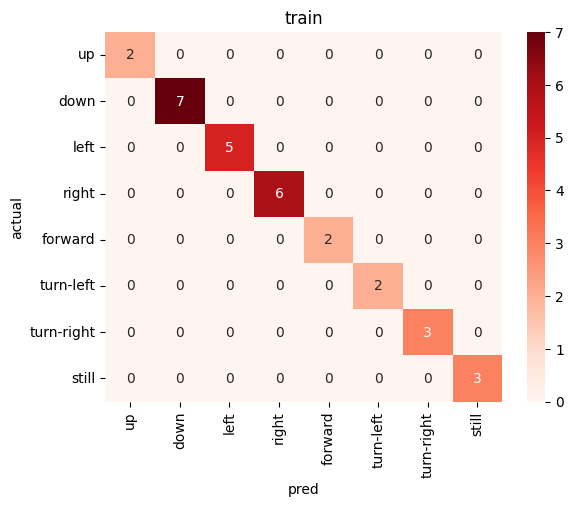

In [9]:
conf_matrix = confusion_matrix(Yte, YteHat)
labels = np.array(list(numToWord.values()))
df = pd.DataFrame(conf_matrix, index = labels,
                  columns = labels)
sns.heatmap(df, annot=True, cmap="Reds")
plt.title('train')
plt.xlabel('pred')
plt.ylabel('actual')
plt.show()

In [10]:
# Export model to file
with open('model.pkl','wb') as f:
    pickle.dump(svm_classifier,f)

This next cell will need to be put into our python implementation for the model

In [11]:
# Load model from file
with open('model.pkl', 'rb') as f:
    svm_classifierReloaded = pickle.load(f)

In [12]:
# Classify new data
newData = XteFlat #example
obsNumDirs = svm_classifierReloaded.predict(newData)
obsWordDirs = [numToWord[obsNumDir] for obsNumDir in obsNumDirs]
print('We classify those actions as:', obsWordDirs)

We classify those actions as: ['left', 'turn-left', 'right', 'right', 'right', 'turn-right', 'down', 'down', 'still', 'up', 'left', 'left', 'right', 'down', 'right', 'still', 'down', 'down', 'still', 'forward', 'up', 'left', 'turn-right', 'down', 'turn-right', 'down', 'right', 'left', 'turn-left', 'forward']


### Deprecated

In [ ]:
# deprecated for analyzing confidence on random data versus test and train data when considering identifying idle data
fig, ax = plt.subplots()
ax.set_ylabel('confidence (%)')
bplot = ax.boxplot([trainConfidences, testConfidences, randomConfidences], patch_artist=True)
plt.xticks([1, 2, 3], ['train', 'test', 'random'])
plt.show()